Condition number of N: 1.44e+04


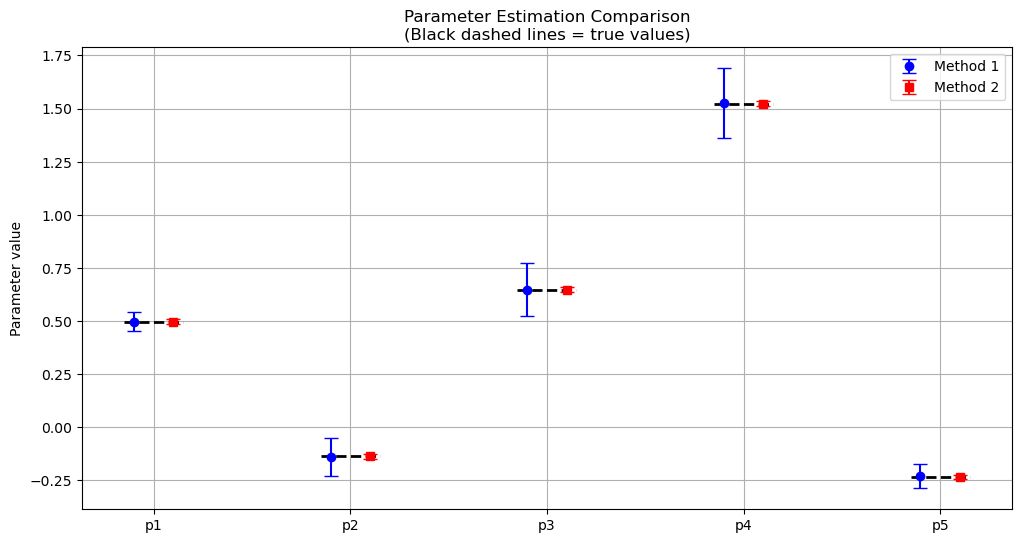


True parameters: [ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337]
Method 1 means:   ['0.497', '-0.140', '0.647', '1.525', '-0.232']
Method 2 means:   ['0.496', '-0.138', '0.648', '1.523', '-0.234']
Method 1 stds:    ['0.045', '0.090', '0.124', '0.164', '0.056']
Method 2 stds:    ['0.012', '0.010', '0.010', '0.013', '0.010']


In [1]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

# Parameters
n_samples = 1000  # Number of Monte Carlo samples
n = 100           # Number of data points
k = 5             # Number of parameters
rho = 0.99        # Correlation coefficient for 1/f-like noise
np.random.seed(42)

# True parameters and design matrix
p_true = np.random.randn(k)
A = np.random.randn(n, k)
mu = A @ p_true

# Construct covariance matrix with correlated noise
c = rho ** np.arange(n)  # Exponential decay for Toeplitz structure
N = scipy.linalg.toeplitz(c) + 1e-4 * np.eye(n)  # Regularize for numerical stability

# Compute inverse (potentially unstable)
N_inv = np.linalg.inv(N)
print(f"Condition number of N: {np.linalg.cond(N):.2e}")

# Cholesky decomposition for noise generation
L = scipy.linalg.cholesky(N, lower=True)

# Storage for estimates
p_est1 = np.zeros((n_samples, k))
p_est2 = np.zeros((n_samples, k))

for i in range(n_samples):
    # Generate correlated noise
    z = np.random.randn(n)
    noise = L @ z
    
    # Method 1: Naive OLS-style solution
    rhs1 = A.T @ (mu + noise)
    p1 = np.linalg.solve(A.T @ A, rhs1)
    p_est1[i] = p1
    
    # Method 2: Textbook GLS-style solution
    rhs2 = A.T @ N_inv @ (mu + noise)
    p2 = np.linalg.solve(A.T @ N_inv @ A, rhs2)
    # try:
    #     p2 = np.linalg.solve(A.T @ N_inv @ A, rhs2)
    # except np.linalg.LinAlgError:
    #     p2 = np.linalg.lstsq(A.T @ N_inv @ A, rhs2, rcond=None)[0]
    p_est2[i] = p2

# Calculate statistics
mean_p1 = p_est1.mean(axis=0)
mean_p2 = p_est2.mean(axis=0)
std_p1 = p_est1.std(axis=0)
std_p2 = p_est2.std(axis=0)

# Plot results
plt.figure(figsize=(12, 6))
for i in range(k):
    plt.errorbar(i-0.1, mean_p1[i], yerr=std_p1[i], fmt='o', 
                 color='blue', capsize=5, label='Method 1' if i==0 else None)
    plt.errorbar(i+0.1, mean_p2[i], yerr=std_p2[i], fmt='s',
                 color='red', capsize=5, label='Method 2' if i==0 else None)
    plt.plot([i-0.15, i+0.15], [p_true[i]]*2, 'k--', lw=2)

plt.xticks(range(k), [f'p{i+1}' for i in range(k)])
plt.ylabel('Parameter value')
plt.title('Parameter Estimation Comparison\n(Black dashed lines = true values)')
plt.legend()
plt.grid(True)
plt.show()

# Print numerical results
print("\nTrue parameters:", p_true)
print("Method 1 means:  ", [f"{x:.3f}" for x in mean_p1])
print("Method 2 means:  ", [f"{x:.3f}" for x in mean_p2])
print("Method 1 stds:   ", [f"{x:.3f}" for x in std_p1])
print("Method 2 stds:   ", [f"{x:.3f}" for x in std_p2])

Condition number of N: 1.47e+04


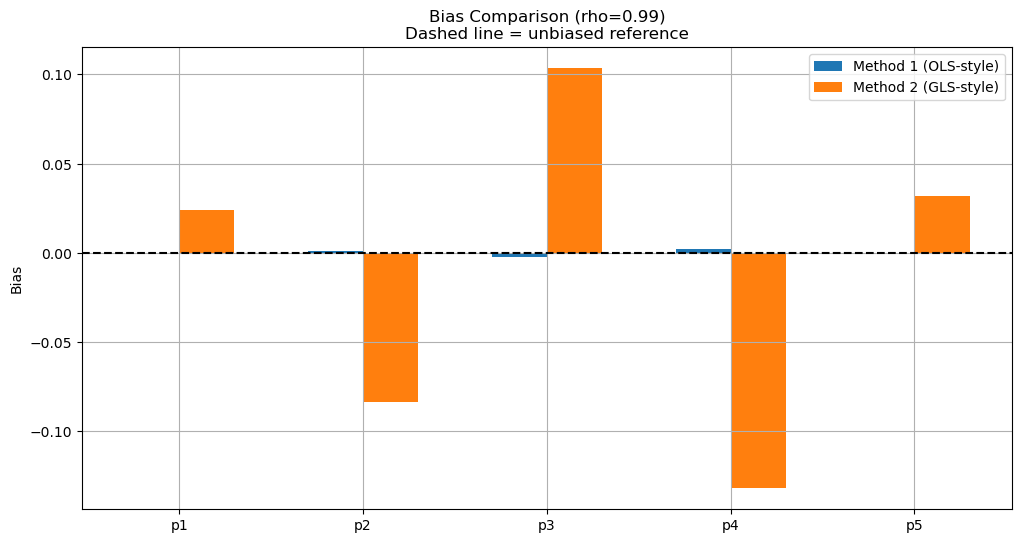

True parameters: [-0.02438807  0.0835974  -0.10334995  0.13151404 -0.03233632]
Method 1 bias:   ['-8.532e-04', '1.157e-03', '-2.158e-03', '2.275e-03', '-6.029e-04']
Method 2 bias:   ['2.406e-02', '-8.360e-02', '1.035e-01', '-1.319e-01', '3.205e-02']


In [2]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

# Parameters
n_samples = 1000  # Number of Monte Carlo samples
n = 100           # Number of data points
k = 5             # Number of parameters
rho = 0.99        # Correlation coefficient for noise
np.random.seed(42)

# Design matrix and true parameters
A = np.random.randn(n, k)
mu = np.ones(n)  # Constant mean vector
p_true = np.linalg.lstsq(A, mu, rcond=None)[0]  # Best-fit true parameters

# Construct correlated noise covariance matrix
c = rho ** np.arange(n)
N = scipy.linalg.toeplitz(c) + 1e-6 * np.eye(n)  # Regularized
L = scipy.linalg.cholesky(N, lower=True)

# Precompute inverse (for Method 2)
N_inv = np.linalg.inv(N)
print(f"Condition number of N: {np.linalg.cond(N):.2e}")

# Storage for estimates
p_est1 = np.zeros((n_samples, k))
p_est2 = np.zeros((n_samples, k))

for i in range(n_samples):
    # Generate correlated noise
    noise = L @ np.random.randn(n)
    y = mu + noise  # Observed data
    
    # Method 1: Standard OLS (ignores N^{-1})
    rhs1 = A.T @ y
    p1 = np.linalg.solve(A.T @ A, rhs1)
    p_est1[i] = p1
    
    # Method 2: Textbook GLS (uses N^{-1})
    rhs2 = A.T @ N_inv @ y
    try:
        p2 = np.linalg.solve(A.T @ N_inv @ A, rhs2)
    except np.linalg.LinAlgError:
        p2 = np.linalg.lstsq(A.T @ N_inv @ A, rhs2, rcond=None)[0]
    p_est2[i] = p2

# Calculate statistics
mean_p1 = p_est1.mean(axis=0)
mean_p2 = p_est2.mean(axis=0)
bias_p1 = mean_p1 - p_true
bias_p2 = mean_p2 - p_true

# Plot results
plt.figure(figsize=(12, 6))
plt.bar(np.arange(k)-0.15, bias_p1, width=0.3, label='Method 1 (OLS-style)')
plt.bar(np.arange(k)+0.15, bias_p2, width=0.3, label='Method 2 (GLS-style)')
plt.xticks(range(k), [f'p{i+1}' for i in range(k)])
plt.axhline(0, color='k', linestyle='--')
plt.ylabel('Bias')
plt.title(f'Bias Comparison (rho={rho})\nDashed line = unbiased reference')
plt.legend()
plt.grid(True)
plt.show()

# Print numerical results
print("True parameters:", p_true)
print("Method 1 bias:  ", [f"{x:.3e}" for x in bias_p1])
print("Method 2 bias:  ", [f"{x:.3e}" for x in bias_p2])

In [3]:
p_true

array([-0.02438807,  0.0835974 , -0.10334995,  0.13151404, -0.03233632])

In [4]:
mean_p2

array([-3.31934913e-04, -3.57238969e-07,  1.32692904e-04, -3.92055560e-04,
       -2.88167418e-04])

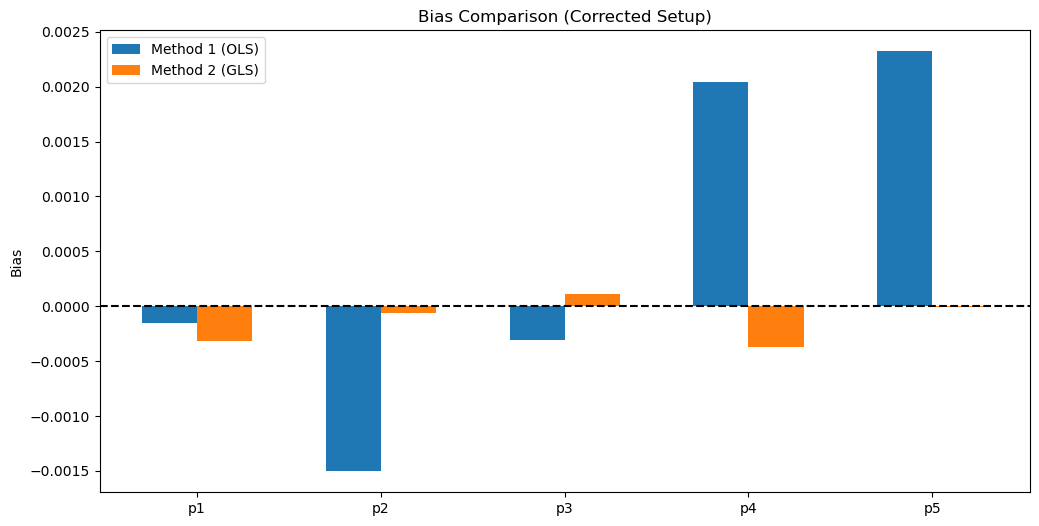

In [5]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

# Parameters
n_samples = 1000
n = 100
k = 5
rho = 0.99
np.random.seed(42)

# True parameters and design matrix
p_true = np.random.randn(k)  # Ground truth
A = np.random.randn(n, k)
mu = A @ p_true  # Correct: mu lies in column space of A

# Noise covariance
c = rho ** np.arange(n)
N = scipy.linalg.toeplitz(c) + 1e-6 * np.eye(n)
L = scipy.linalg.cholesky(N, lower=True)
N_inv = np.linalg.inv(N)

# Storage
p_est1 = np.zeros((n_samples, k))
p_est2 = np.zeros((n_samples, k))

for i in range(n_samples):
    noise = L @ np.random.randn(n)
    y = mu + noise
    
    # Method 1
    rhs1 = A.T @ y
    p1 = np.linalg.solve(A.T @ A, rhs1)
    p_est1[i] = p1
    
    # Method 2
    rhs2 = A.T @ N_inv @ y
    p2 = np.linalg.solve(A.T @ N_inv @ A, rhs2)
    p_est2[i] = p2

# Calculate bias (relative to shared p_true)
bias_p1 = p_est1.mean(axis=0) - p_true
bias_p2 = p_est2.mean(axis=0) - p_true

# Plot results
plt.figure(figsize=(12, 6))
plt.bar(np.arange(k)-0.15, bias_p1, width=0.3, label='Method 1 (OLS)')
plt.bar(np.arange(k)+0.15, bias_p2, width=0.3, label='Method 2 (GLS)')
plt.xticks(range(k), [f'p{i+1}' for i in range(k)])
plt.axhline(0, color='k', linestyle='--')
plt.ylabel('Bias')
plt.title('Bias Comparison (Corrected Setup)')
plt.legend()
plt.show()

In [6]:
import numpy as np
import scipy.linalg

def sample_p(d, U, N, n_samples=1):
    """
    Sample p from the posterior distribution given data d, 
    model matrix U, and noise covariance N.
    
    Args:
        d: Observed data vector (n,)
        U: Model matrix (n, k)
        N: Noise covariance matrix (n, n)
        n_samples: Number of samples to draw
    
    Returns:
        p_samples: Samples from p's posterior (n_samples, k)
    """
    n, k = U.shape
    
    # Construct A = diag(d) @ U
    A = np.diag(d) @ U
    
    # GLS estimator components
    try:
        N_inv = np.linalg.inv(N)
    except np.linalg.LinAlgError:
        # Regularize if N is singular
        N_reg = N + 1e-6 * np.eye(n)
        N_inv = np.linalg.inv(N_reg)
    
    # Compute GLS solution
    ATA = A.T @ N_inv @ A
    rhs = A.T @ N_inv @ np.ones(n)  # RHS vector is 1
    
    try:
        p_mean = np.linalg.solve(ATA, rhs)
    except np.linalg.LinAlgError:
        # Fallback to least squares if singular
        p_mean = np.linalg.lstsq(ATA, rhs, rcond=None)[0]
    
    # Posterior covariance
    try:
        cov_p = np.linalg.inv(ATA)
    except np.linalg.LinAlgError:
        cov_p = np.linalg.pinv(ATA)
    
    # Sample from multivariate normal
    p_samples = np.random.multivariate_normal(p_mean, cov_p, size=n_samples)
    
    return p_samples

# Example usage
n = 100
k = 3
np.random.seed(42)

# True parameters
p_true = np.array([1.0, -0.5, 2.0])

# Generate synthetic data
U = np.random.randn(n, k)
true_signal = U @ p_true

# Create correlated noise (1/f-like)
rho = 0.95
c = rho ** np.abs(np.arange(n)[:, None] - np.arange(n))
N = scipy.linalg.toeplitz(rho ** np.arange(n)) + 1e-4 * np.eye(n)
n_noise = np.random.multivariate_normal(np.zeros(n), N)

# Generate observed data (following d = (1+n)/(U@p)
d = (1 + n_noise) / (U @ p_true)

# Sample p
p_samples = sample_p(d, U, N, n_samples=1000)

# Analysis
print("True p:", p_true)
print("Estimated mean:", np.mean(p_samples, axis=0))
print("Standard deviation:", np.std(p_samples, axis=0))

True p: [ 1.  -0.5  2. ]
Estimated mean: [ 0.05783107 -0.02877113  0.11642276]
Standard deviation: [0.10957878 0.05493976 0.21879633]


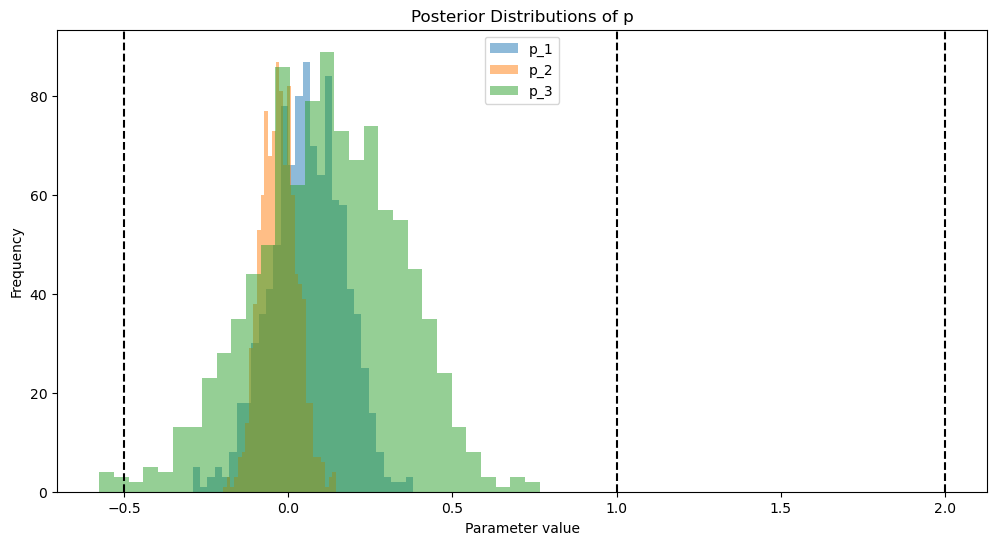

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i in range(k):
    plt.hist(p_samples[:, i], bins=30, alpha=0.5, label=f'p_{i+1}')
    plt.axvline(p_true[i], color='k', linestyle='--')
plt.xlabel('Parameter value')
plt.ylabel('Frequency')
plt.title('Posterior Distributions of p')
plt.legend()
plt.show()

In [8]:
import numpy as np
from scipy.optimize import minimize

def log_likelihood(p, U, d, N_inv):
    Up = U @ p
    residual = (d / Up) - 1  # Residual: n = (d/(Up)) - 1
    return -0.5 * residual.T @ N_inv @ residual

def sample_p_fast(U, d, N, n_samples=1000, max_iter=100):
    n, k = U.shape
    N_inv = np.linalg.inv(N)
    
    # Initial guess for p (naive OLS ignoring noise structure)
    p0 = np.linalg.lstsq(U, d, rcond=None)[0]
    
    # Optimize using MLE
    result = minimize(
        lambda p: -log_likelihood(p, U, d, N_inv),
        p0,
        method='BFGS',
        options={'maxiter': max_iter}
    )
    p_mle = result.x
    
    # Approximate covariance using Hessian at MLE
    H = result.hess_inv if hasattr(result, 'hess_inv') else np.linalg.inv(np.linalg.pinv(U.T @ U))
    p_samples = np.random.multivariate_normal(p_mle, H, size=n_samples)
    
    return p_samples

# Example usage
n = 100
k = 3
U = np.random.randn(n, k)
p_true = np.array([1.0, -0.5, 2.0])
N = np.eye(n)  # Replace with your covariance matrix

# Generate data with multiplicative noise
n_noise = np.random.multivariate_normal(np.zeros(n), N)
d = U @ p_true * (1 + n_noise)

# Sample p
p_samples = sample_p_fast(U, d, N, n_samples=1000)

In [9]:
print("True p:", p_true)
print("Sampled mean:", np.mean(p_samples, axis=0))
print("Sampled std:", np.std(p_samples, axis=0))

True p: [ 1.  -0.5  2. ]
Sampled mean: [ 2.22434091 -0.14639488  4.92172296]
Sampled std: [0.43455103 0.20657029 0.93516148]


In [10]:
import numpy as np
from scipy.linalg import solve
from numpy.linalg import cholesky


# def iterative_gls(U, d, N, tol=1e-10, max_iter=1000):
#     """
#     Iteratively solves for p using GLS with heteroskedastic noise.

#     Data model: d = U p (1 + n), where n ~ Gaussian(0, N).
    
#     Parameters:
#     U : ndarray (M, N)
#         Projection matrix
#     d : ndarray (M,)
#         Observed data
#     N : ndarray (M, M)
#         Covariance matrix of noise (assumed positive definite)
#     tol : float
#         Convergence tolerance
#     max_iter : int
#         Maximum number of iterations

#     Returns:
#     p_gls : ndarray (N,)
#         Estimated parameter vector p
#     Sigma_inv : ndarray (M, M)
#         Covariance matrix for sampling
#     """
#     # Initialize p using ordinary least squares (OLS) as a starting point
#     p = np.linalg.lstsq(U, d, rcond=None)[0]  
    
#     for iteration in range(max_iter):
#         # Compute noise covariance Σ_ε = diag(U p) N diag(U p)
#         D_p = np.diag(U @ p)
#         Sigma_epsilon = D_p @ N @ D_p

#         # Solve GLS: (U^T Σ_ε⁻¹ U) p = U^T Σ_ε⁻¹ d
#         Sigma_inv = np.linalg.inv(Sigma_epsilon)
#         UTSigma_invU = U.T @ Sigma_inv @ U
#         UTSigma_invD = U.T @ Sigma_inv @ d
#         p_new = solve(UTSigma_invU, UTSigma_invD)

#         # Check for convergence
#         if np.linalg.norm(p_new - p) < tol:
#             break
#         p = p_new

#     # Compute final covariance for posterior sampling
#     # covariance_p = np.linalg.inv(U.T @ Sigma_inv @ U)

#     return p, Sigma_inv

# def sample_p(d, U, Sigma_inv, num_samples=1):
#     """
#     Draw samples from the likelihood distribution of p.

#     Parameters:
#     d : ndarray (M,)
#         Observed data
#     U : ndarray (M, N)
#         Projection matrix
#     Sigma_inv : ndarray (M, M)
#         Inverse of noise covariance matrix Σ_ε
#     num_samples : int
#         Number of samples to draw

#     Returns:
#     samples : ndarray (num_samples, N)
#         Samples of p from likelihood distribution
#     """
#     A = U.T @ Sigma_inv @ U
#     aux = Sigma_inv @ d
#     Sigma_sqrt_inv = np.transpose(cholesky(Sigma_inv))
#     num_d = len(d)
#     _, N = U.shape
#     p_samples = np.zeros((num_samples, N))
    
#     for i in range(num_samples):
#         b = aux + Sigma_sqrt_inv @ np.random.randn(num_d)
#         b = U.T @ b
#         p_samples[i,:] = solve(A, b)

#     return p_samples

from linear_sampler import *


In [11]:
from flicker_model import flicker_cov, sim_noise
from utils import Leg_poly_proj


t_list = np.arange(3000)*2
sigma_2 = 1/(4e5)

proj = Leg_poly_proj(4, t_list) # Projector "U"
params = np.array([2, 0.5, 1.5, 0.5]) # True "p"

f0, fc, alpha = 1e-4, 2e-5, 2.0

noise = sim_noise(f0, fc, alpha, t_list, n_samples=1, white_n_variance=sigma_2)[0]

data = (proj @ params) * (1 + noise)

Ncov = flicker_cov(t_list, f0, fc, alpha, white_n_variance=sigma_2, only_row_0=False)

In [12]:
p_GLS, sigma_inv = iterative_gls(proj, data, Ncov, tol=1e-10, max_iter=1000)
# Compare p_GLS with the true "params"
# Print results
print("Estimated p:", p_GLS)
print("True p:", params)

Converged in 5 iterations.
Estimated p: [2.02817565 0.49887821 1.53381872 0.51477826]
True p: [2.  0.5 1.5 0.5]



Gain Parameter 1:
True value: 2.000000
Mean sampled: 2.009733
Standard deviation: 0.842840
Relative error: 0.49%

Gain Parameter 2:
True value: 0.500000
Mean sampled: 0.492202
Standard deviation: 0.268055
Relative error: 1.56%

Gain Parameter 3:
True value: 1.500000
Mean sampled: 1.519652
Standard deviation: 0.645901
Relative error: 1.31%

Gain Parameter 4:
True value: 0.500000
Mean sampled: 0.509148
Standard deviation: 0.230006
Relative error: 1.83%


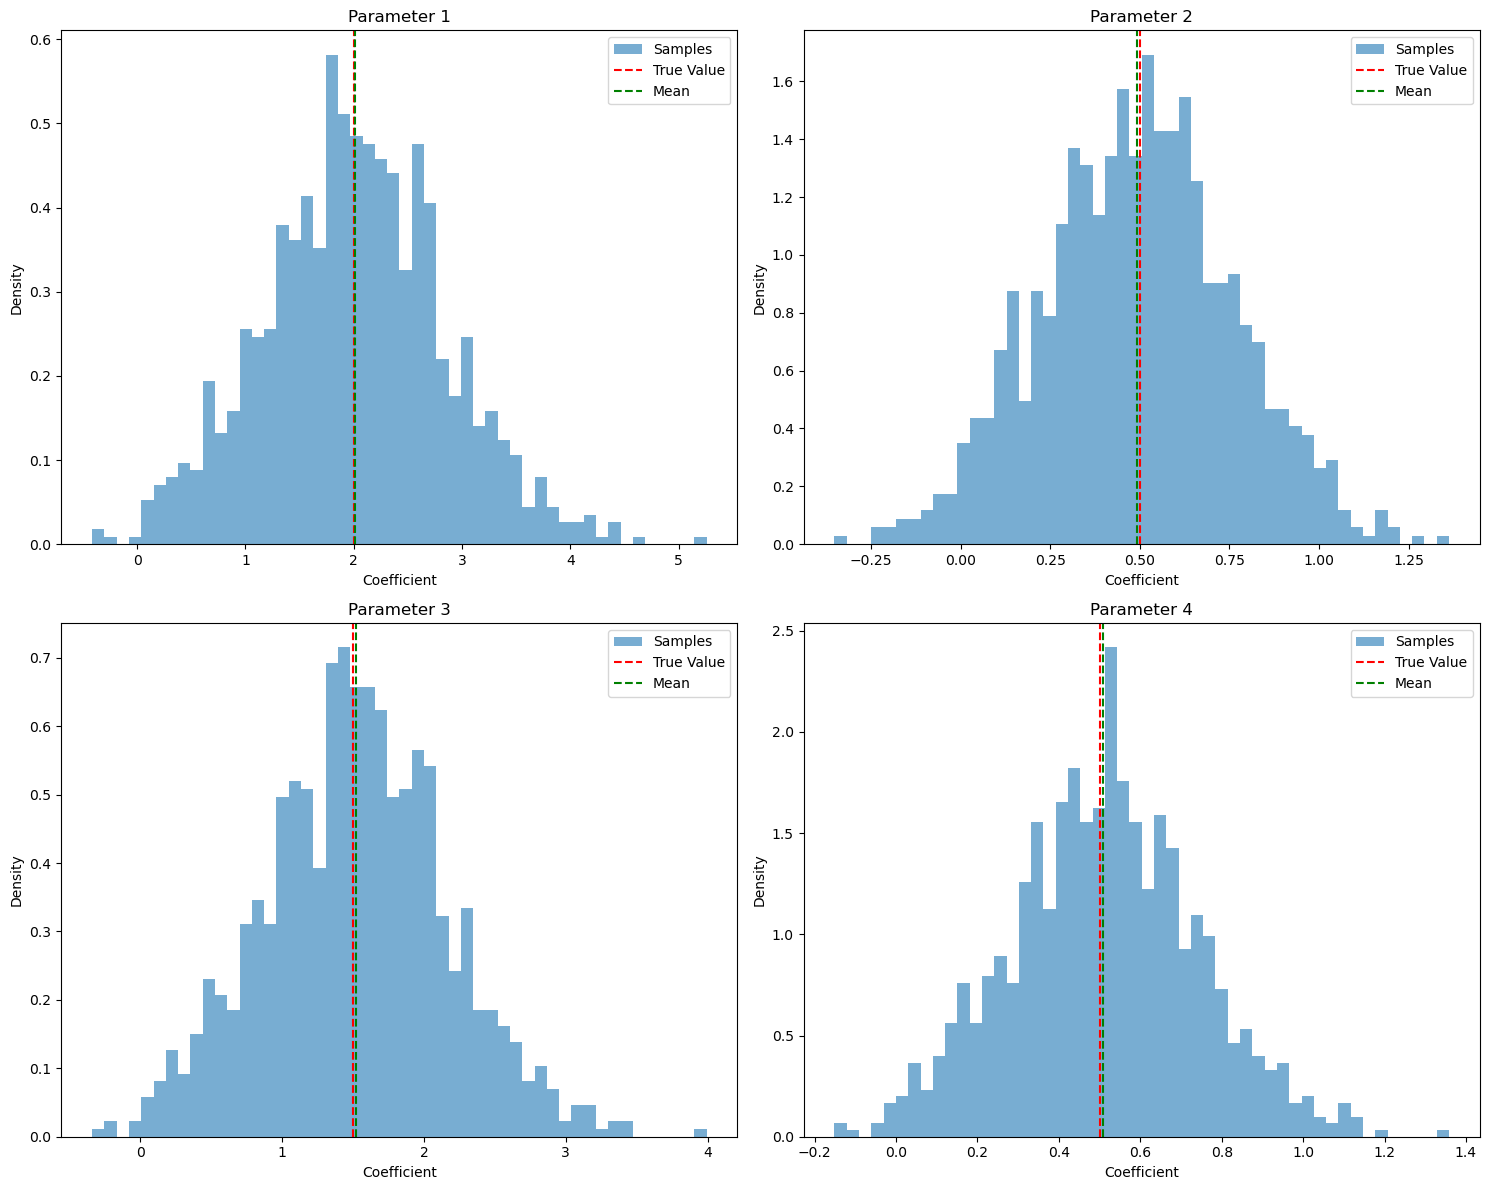

In [13]:
params_samples = sample_p(data, proj, sigma_inv, num_samples=1000)

# Calculate statistics
mean = np.mean(params_samples, axis=0)
std = np.std(params_samples, axis=0)

# Create subplots for four parameters
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i in range(4):
    # Plot histogram of samples for each parameter
    axes[i].hist(params_samples[:, i], bins=50, density=True, alpha=0.6, label='Samples')
    
    # Plot true value line
    axes[i].axvline(x=params[i], color='r', linestyle='--', label='True Value')
    
    # Plot mean value line
    axes[i].axvline(x=mean[i], color='g', linestyle='--', label='Mean')
    
    # Add labels and title
    axes[i].set_xlabel('Coefficient')
    axes[i].set_ylabel('Density')
    axes[i].set_title(f'Parameter {i+1}')
    axes[i].legend()
    
    # Print numerical comparison for each parameter
    print(f"\nGain Parameter {i+1}:")
    print(f"True value: {params[i]:.6f}")
    print(f"Mean sampled: {mean[i]:.6f}")
    print(f"Standard deviation: {std[i]:.6f}")
    print(f"Relative error: {abs(mean[i] - params[i])/params[i]*100:.2f}%")

plt.tight_layout()
plt.show()